In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from bresenham import bresenham
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from sklearn.neighbors import KDTree
from planning_utils_random_sampling import a_star, heuristic, create_grid
%matplotlib inline 
import sys
# ! pip install -I networkx==2.1
import pkg_resources
# pkg_resources.require("networkx==2.1")
import networkx as nx
print(nx.__version__)
plt.rcParams['figure.figsize'] = 14, 14

2.1


In [4]:
def get_data_coords(data):
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))
    
    return north_min, north_max, east_min, east_max, north_size, east_size

## create obstacle graph

In [5]:
def create_obstacle_graph(north_info, east_info, data):
    polygons = []
    polygons_center = []
    for row in data:
        north, east, alt, d_north, d_east, d_alt = row
        obstacle = [
            int(np.clip(north - d_north - SAFETY_DISTANCE - north_info['min'], 0, north_info['size']-1)),
            int(np.clip(north + d_north + SAFETY_DISTANCE - north_info['min'], 0, north_info['size']-1)),
            int(np.clip(east - d_east - SAFETY_DISTANCE - east_info['min'], 0, east_info['size']-1)),
            int(np.clip(east + d_east + SAFETY_DISTANCE - east_info['min'], 0, east_info['size']-1)),
        ]
        corner_0= (obstacle[0], obstacle[2])
        corner_1= (obstacle[0], obstacle[3])
        corner_2= (obstacle[1], obstacle[3])
        corner_3= (obstacle[1], obstacle[2])
        poly = Polygon([corner_0, corner_1, corner_2, corner_3])
        height = alt + d_alt + SAFETY_DISTANCE
        polygons.append((poly,height))
        polygons_center.append((poly.centroid.x, poly.centroid.y))

    obstacle_tree = KDTree(polygons_center, metric='euclidean')
    return obstacle_tree, polygons

## random sampling and refining the points with collision

In [6]:
def generate_samples(north, east, data, obstacle_tree, start,  goal):
    n_sample= 300
    x_samples = np.random.uniform(north['min'], north['max'], n_sample)
    y_samples = np.random.uniform(east['min'], east['max'], n_sample)
    z_samples = np.random.uniform(0, TARGET_ALTITUDE, n_sample)

    random_samples = list(zip(x_samples,y_samples,z_samples))
    random_samples.append(start)
    random_samples.append(goal)
    nodes = []
    max_xy = 2*np.max((data[:,3], data[:,4]))
    for sample in random_samples:
        collision = False
        idx = list(obstacle_tree.query_radius(np.array([sample[0],sample[1]]).reshape(1,-1), r=max_xy)[0])
        for obstacle_id in idx:
            poly, height = polygons[obstacle_id]
            # polygon heigh is already gapped with safety_distance
            if poly.contains(Point(sample)) and sample[2] <= height :
                collision = True
                if sample == goal:
                    print('GOAL REMOVED')
        if collision is False:
            nodes.append(sample)
    return nodes, random_samples

## creating global graph and detecting collision

In [7]:


def can_connect(node1,node2, polygons):
    line = LineString([node1, node2])
    for poly, height in polygons:
        # polygon heigh is already gapped with safety_distance
        if poly.crosses(line) and min(node1[2],node2[2]) <= height: 
            return False
    return True

def create_graph(nodes):
    sample_tree = KDTree(nodes)
    graph = nx.Graph()
    for node in nodes:
        neighbors = list(sample_tree.query([node], k=10, return_distance=False)[0])
        for index  in neighbors:
            other_node = nodes[index]
            if node!=other_node and can_connect(node,other_node, polygons):
                 graph.add_edge(node, other_node, weight=1)
    return graph, sample_tree

In [8]:
def a_star(graph, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    branch[next_node] = (new_cost, current_node)
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

def heuristic(position, goal_position):
    return np.linalg.norm(np.array(position) - np.array(goal_position))



In [9]:
import numpy
from udacidrone.frame_utils import global_to_local, local_to_global

def get_random_point():
    point = list(graph.nodes)[np.random.randint(len(graph.nodes))]
    global_home = np.array([-122.39745 ,  37.79248 ,   0.     ])


    temp_point_1=(point[0] + north_offset, point[1] + east_offset, 0)
    # temp_point_1=(point[0] , point[1] , 0)
    geodetic_current_coordinates = local_to_global(temp_point_1, global_home)
    local_position = global_to_local(geodetic_current_coordinates, global_home)
    global_position  = (int(local_position[0]-north_offset), int(local_position[1]-east_offset))

    print("Point from the graph: ",point)
    print("Point localized: ",local_position)
    print("Point global: ", global_position)
    return point

ModuleNotFoundError: No module named 'udacidrone'

In [42]:
# #calculate path & cost
# start = get_random_point()
# goal = get_random_point()

# lat_goal = 37.79350542
# lon_goal = -122.39704412
# point = (lon_goal, lat_goal, 0)
# global_home = np.array([-122.39745 ,  37.79248 ,   0.     ])
# local = global_to_local(point,global_home)
# goal=(point[0] + north_offset, point[1] + east_offset, 0)
# print(temp_point_1)

In [43]:
def find_closest_node(node, graph, sample_tree, nodes, polygons):
    neighbors = list(sample_tree.query([node], k=10, return_distance=False)[0])
    closest_node = None
    if len(neighbors)>0:
        min_dist= 10000
        for ind in neighbors:
            neighbor = nodes[ind]
            all_nodes = list(graph.nodes)
            if neighbor in list(graph.nodes):
                dist = np.linalg.norm(np.array(neighbor) - np.array(node))
                if dist < min_dist and can_connect(node,neighbor, polygons):
                    closest_node = neighbor
                    min_dist = dist
        return closest_node
    else: 
        return None
    
    

In [22]:
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)




north_min, north_max, east_min, east_max, north_size, east_size = get_data_coords(data)
north_info={'min':north_min, 'max':north_max, 'size':north_size}
east_info ={'min':east_min, 'max':east_max, 'size':east_size}


# (316, 445) (326, 455)
grid_start = (316, 445, 0) 
grid_goal = (400, 520, 0)

grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
obstacle_tree, polygons = create_obstacle_graph(north_info, east_info, data)

nodes, samples = generate_samples(north_info, east_info, data,obstacle_tree, grid_start, grid_goal)        
print('keeping {} nodes from {} random samples'.format(len(nodes), len(samples)))

print('Generating random sampled graph...')
graph,sample_tree = create_graph(nodes)
print('Done!')

keeping 239 nodes from 302 random samples
Generating random sampled graph...
Done!


(316, 445, 0)
(400, 520, 0)
Found a path.



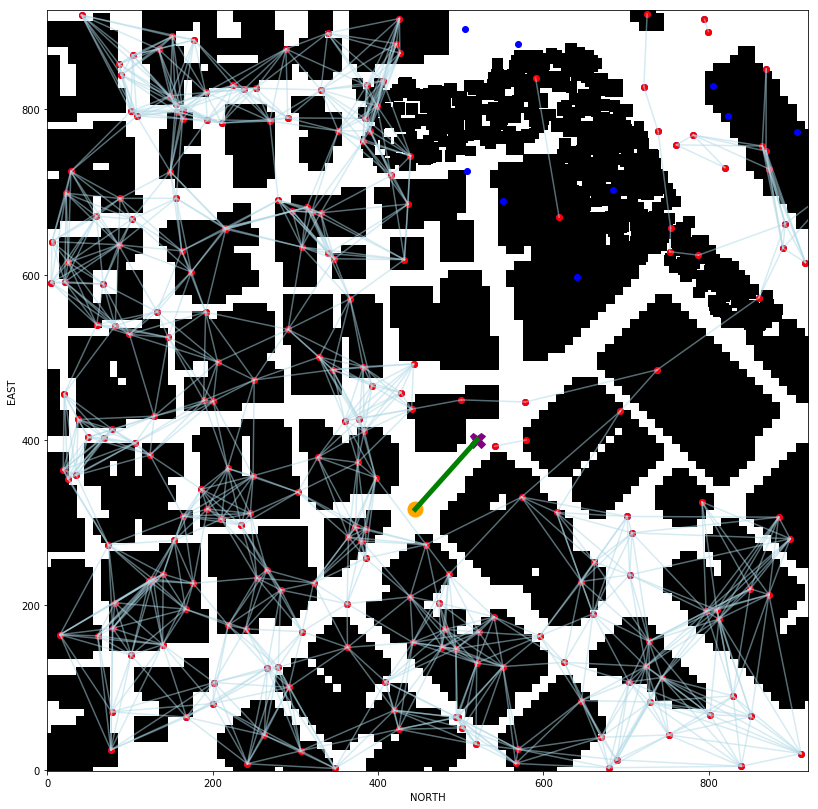

In [23]:
#Local Start and Goal:  
# some_start = get_random_point()
# some_goal = get_random_point()
# near_start = find_closest_node(some_start, graph, sample_tree, nodes, polygons) 
# near_goal = find_closest_node(some_goal, graph, sample_tree, nodes, polygons)


print(grid_start)
print(grid_goal)


path,path_cost = a_star(graph, heuristic, grid_start, grid_goal) 
path_pairs = zip(path[:-1], path[1:])
                     
nmin =  north_min 
emin = east_min 

# Draw edges
for (n1, n2) in graph.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'lightblue' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# # Draw connected nodes in red
for n1 in graph.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
 

plt.plot(grid_start[1], grid_start[0], marker='o', linewidth=5, markersize=15, c='orange')
plt.plot(grid_goal[1], grid_goal[0], marker='X', linewidth=5, markersize=15, c='purple')

path_pairs = zip(path[:-1], path[1:])
print()
for (n1, n2) in path_pairs:
    plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'green', linewidth=5)

plt.imshow(grid, cmap='Greys', origin='lower')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

In [17]:
print(path)

[(316, 445, 0), (326, 455, 0)]
